---

::: {.callout-note collapse="true"}
## TLDR

I trained a model for my app EyesOff, which detects when people are looking at your screen to protect you from shoulder surfing. With no existing dataset for this task, I hand-labelled 20k+ images for training and created synthetic gaze labels for pre-training. The final model achieves ~71% accuracy across close and mid-range distances.

:::

### Why Do I Need a Custom Model?

For the past 3 months I have been working to create a model to detect whether or not someone is looking at a screen. This blog recounts the steps I took to train such a model.

I am building this model for <a href="https://www.eyesoff.app">EyesOff</a>. It's an application which detects people looking at your screen. The aim is to keep you safe from shoulder surfing, utilising your webcam to give you the power to prevent snoopers. 

The first model I considered for the app was the Eye-Contact-CNN[<sup>1</sup>](#1), which was trained to detect eye contact in children. However, due to its license I cannot use it in EyesOff. Also, this model is too restrictive, as it only classifies as looking if the person looks directly at the camera. Making the Eye-Contact-CNN too specific for EyesOff.

Nevertheless, I am grateful to the authors as their paper is immensely useful in detailing its approach. Because I could not use it out of the box, it led me on a journey to build my own dataset & model.

---

::: {.callout-note collapse="true"}
## The Other Approaches I Tried 

Before deciding to build a custom deep learning model I tried a number of different approaches, I won't go in to details here but feel free to reach out if you want to know more on any of these approaches[<sup>7</sup>](#7). Here's a quick list:

    - eye-contact-cnn - it was too restrictive in boundaries for detection.
    - mediapipe - I tried to use landmarks and headpose as heuristic 
      approximations, setting thresholds for looking and not looking,
      but this was too fragile.
    - gaze detection + estimation models - another approach of setting 
      manual thresholds for angles which were looking at the screen.
      I also considered a calibration based approach, e.g. show the user some
      calibration spots and use that to build the bounds of their screen.
      This works for the main user, but breaks down when the algorithm see's
      a head in a position other than the one it was callibrated on (e.g.
      a shoulder surfer). Also, I do not want to expose users to a
      calibration flow, I want the user of EyesOff to have a smooth experience.
      
:::

## Overcoming the Lack of Data

The biggest problem in this whole process was the <b>lack of data</b>. This was my first time training a model for a task which hasn't been performed before. As such, no dataset (that I could find) has been created for such a task. Many face datasets exist but none with the correct labels that I need. The task itself is a binary classification task in which the model predicts whether a person is looking or not looking at the screen.

## Building the Custom Dataset

### First Steps

Given the lack of data, I had to come up with my own dataset. I started by thinking I could only use images of people using their laptops, as this would be the closest to what the model would see in production. However, this type of data was quite hard to come by. In fact, all I need is people in the image that are facing towards the camera, as this is essentially what the webcam will see. I.e. we take images with people in them and assume that the camera is a webcam at the top of an imaginary display. This allowed me to widen the range of possible data I could use.

Initially, I thought I could do this with images of myself + my friends however I quickly realised this would create issues in terms of generalisability. To get over this I started looking for face datasets which I would label myself.

As a test, I took the FFHQ dataset, having come across it during GAN training. I went through and manually labelled a subset of FFHQ (4900 images) to test my hypothesis. To my eye it worked ok, however it failed on a small test set of images taken of myself. I figured this was because the FFHQ images are quite unlike real life images, Nvidia applied very heavy augmentations to them, making them look a little weird. So, the next step was to find images which looked real. 

Again I began looking for gaze datasets but didn't find much which were easily accessible (GazeFace, MPIIGaze etc require you to sign up to receive and my requests weren't replied to). Until I found the selfie dataset[<sup>2</sup>](#2) on Kaggle. This was a great starting point, from this I took and labelled 3400 images. However, given the dataset is of selfies, a lot of the time faces were occluded by phones, or eyes were looking at the phones, so the data wasn't the best for my use case. I did try labelling only images without phones in, but it didn't help. 

### Developing a Consistent Labelling Framework

A lot of time was spent on developing my labelling framework - i.e. how can I consistently label 1000s of images. I had to iron out "the boundary for someone looking at the screen". I decided to follow the Eye-Contact-CNN paper closely, meaning labelling as looking = directly at the camera or slightly around it, rather than "in the general direction" which was the boundary I began with. I also had to make assumptions on the camera position - to make my life easier I assume a laptop setup where the camera is at the top of the screen. This is a limitation but further work will be done to remove the assumption. Another idea I had was to use the Eye-Contact-CNN to label my data for me, but this did not produce great results. The looking bounds were too tight, the EyesOff model is useless if it only says you are looking if you look directly at the camera, having done this I realised the importance of <b>hand labelled data</b>.

::: {.callout-note collapse="true"}
## YuNet Quirks 

Quick note on YuNet, it struggled to detect faces in 1080 x 1920 images, however halving the resolution seemed to resolve the issue. I'm not sure what caused this.
:::

### Start of the VCD Dataset

Upon observing the limitations of the selfie dataset, namely low quality images and situations which were not close to the production environment of the EyesOff model, I began a search for new datasets. I found the Video Conferencing Dataset (VCD)[<sup>3</sup>](#3). This dataset was created to evaluate video codecs for video conferencing. However, it is also perfect for the EyesOff use case, people in video calls smack in front of the webcam and occasionally looking around. The dataset contains 160 unique individuals in different video conferencing settings. I set to work labelling the dataset, the pipeline goes like this: 

    - Run videos frame by frame but only extract frames at a fixed interval. 
      Extracting every single frame creates issues: firstly, most frames close to 
      each other are the same (diversity in images is important). Also if you 
      have a 30fps video which lasts 30 seconds, each video gives 900 frames. With 
      160 videos you end up with 144,000 images to label!
    
    - Next we take YuNet and run it on the extracted frames, doing this we crop out the 
      faces in each image. I added this step to utilise YuNet, because I love it,
      but more importantly it's an amazing facial detection model and by using it to do the 
      heavy work of detecting faces, we break up our task. YuNet handles facial detection 
      and the EyesOff model only needs to predict if the face is looking or not. 
      It also helps when multiple people are in the scene, making data collection much simpler 
      (imagine having to label images where 3 people are looking but 2 are not, and how would 
      we get diversity in such scenes).It's a bit hacky but it works, also in the production pipeline
      this lets us handle things much easier, we'd get face crops and send them one at a
      time to the EyesOff model, rather than dealing with multiple at once.
    
    - Then I take the face crops and run them through my labeller as before. 
      The labeller was a small tool built to speed up this process, I did look into proper 
      labelling tools such as label studio but found them too heavy for such a use case.
      Using Claude I built a simple labeller, it shows one image at a time,
      with 4 buttons: 1 = label "not looking", 2 = label "looking", 3 = skip and q = go back 
      to previous image. At first labelling was a very slow process, but the more I labelled
      the faster I got. By the end I could label around 1000 images in 15 minutes, 
      to get this fast I would use skip pretty frequently, if a case is too ambiguous 
      it makes more sense to skip it than to waste time labelling it. In the future I 
      will go back and review the skipped cases correctly labelling them and adding them 
      to the train set.
    
    - After labelling the images we can train the model! However we have to be careful 
      in this process, I learnt that facial images need a train-test split.
      By this I mean, the same face cannot appear in train and test, even
      if the image is different. To see why this is required imagine the following: you 
      have a face labelled in 100 different scenarios and poses but it is always looking,
      the model may learn this particular face is always looking and as such when evaluating 
      the test set the result is not reliable.

That's it for the data labelling process for the VCD dataset! All in all I got 5900 images from the VCD dataset. Take a look at Figure 1 for the class distribution.

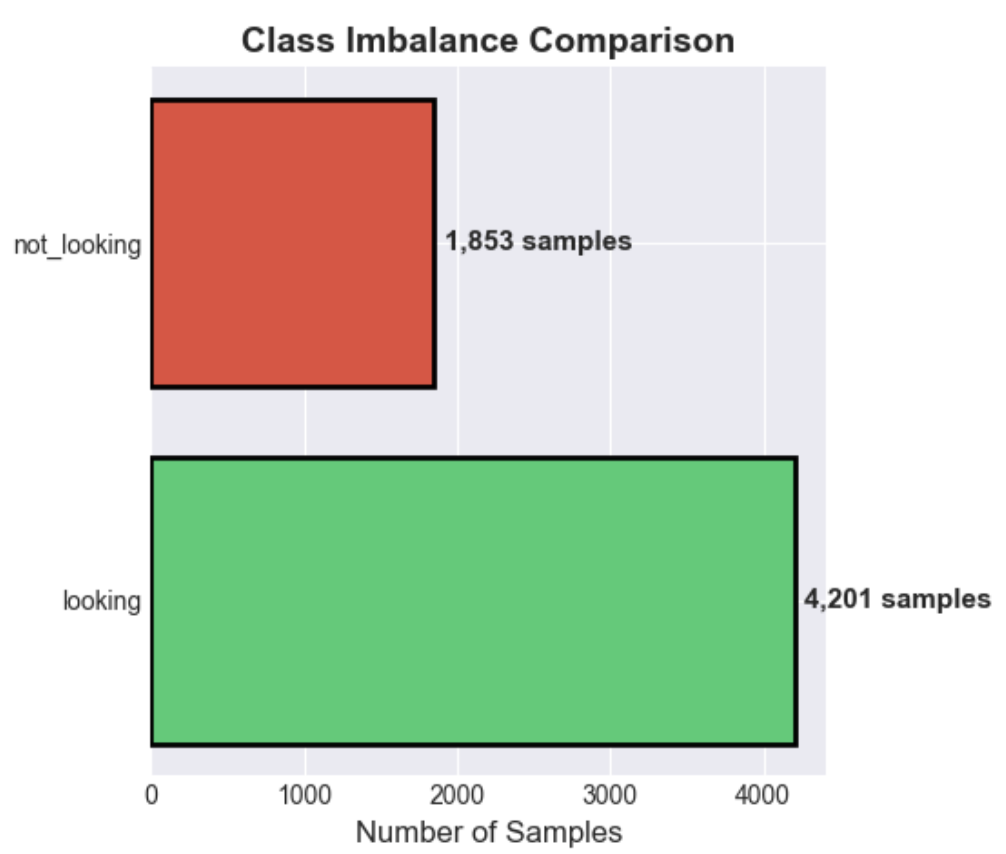

Time to discuss training details!

## Training the EyesOff Model

### Model Choice

Given the nature of EyesOff, being an application which will always run in the background I want the model to be relatively small. YuNet satisfies this, having only 75856 parameters. For the EyesOff model I chose a pre-trained EfficientNetB0 model, which has 5288548 parameters, it is considerably larger than YuNet but still small enough to run on a CPU without affecting performance or draining battery too much.

The decision to use EfficientNetB0 is arbitrary, I could use any other model or architecture and probably get similar or better results. It is definitely worthwhile trying other models. Ultimately however, I think the best approach would probably be to take the YuNet architecture and build the EyesOff model on that. YuNet is so strong for such a small model and I'm sure the architecture can be adapted to give great results in the EyesOff setting. This is future work I endeavour to undertake as the application is built out further. 

### Training the EyesOff Model - A Two Stage Approach

I follow the setup laid out in the Eye-Contact-CNN paper to train my model, with a few changes. The <b>two step</b> process takes a pre-trained ImageNet model as its base. In phase 1 we pre-train on a gaze regression task and in phase 2 we finetune on the screen contact classification task. This approach aids with generalisation. In phase 1, the model learns the relationship between gaze and where a person is looking, this guides the model in how it adapts to phase 2. Essentially, preventing the model from relying on how a face looks or the background etc, by forcing the model to consider the eyes and where they are looking.

#### Phase 1

This approach is very clever, however following it wasn't so straightforward. In phase 1, you need images of faces and the corresponding gaze vector labels. The gaze vector has two values, pitch and yaw. The paper used existing gaze datasets (MPIIFaceGaze, EYEDIAP and SynHead), instead of using these I <b>created a custom gaze regression dataset</b>. To do so, I took the selfie dataset and another dataset of dashcams recording drivers[<sup>4</sup>](#4) and created synthetic gaze vectors. The synthetic gaze vectors are created with a gaze estimation model provided by OpenVino, gaze_estimation_adas_0002 model[<sup>5</sup>](#5). This model requires 3 inputs: left eye crop, right eye crop and the 3 headpose angles. These can be gotten using MediaPipe's facial landmarker model[<sup>6</sup>](#6). This model outputs a mesh of 478 landmarks and a facial transformation matrix. Using the former we can crop out the eyes and with the latter we get the headpose angles. 

Armed with the 3 inputs, we create the gaze vectors and then undertake phase 1 of training. In this phase most blocks of the pre-trained EfficientNetB0 are enabled. We freeze the first 4 blocks, accounting for roughly 5% of total parameter count (as can be seen in figure 2), so <b>95%</b> of the model's weights are available to be updated.

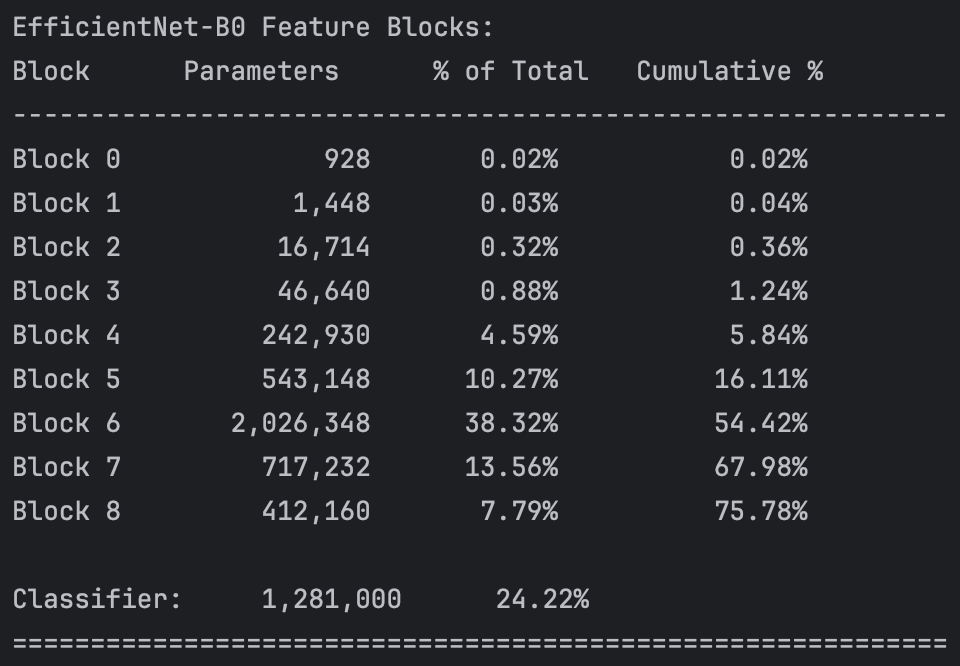

The model is trained for 20 epochs (48000 images in the dataset), using a SmoothL1Loss, learning_rate=5e-5 and weight_decay=1e-4. By the end of training we reach an MAE of $4.35\degree$, in the Eye-Contact-CNN paper <b>convergence for phase 1 is defined as an MAE of less than $6\degree$</b>. With phase 1 complete, we can move on to phase 2 and building the EyesOff model proper. An important caveat here, we used the OpenVino gaze estimation model, and as it is an estimation there is error here and our model is probably not as good as it can be. However, labelling 50k images myself with gaze vectors did not sound fun so here we are. Perhaps making use of the same datasets they did would improve the performance in phase 1 and the EyesOff model as a whole.

#### Phase 2

Phase 1 provides us a strong foundation to start from in phase 2. In phase 2, most of the network is frozen. We unfreeze blocks 7 and onwards which represent, <b>~30%</b> of the networks parameters. The model is trained for 20 epochs, using a BCEWithLogitsLoss, learning_rate=1e-5 and weight_decay=1e-4, on the 5900 images from the VCD dataset. It's a pretty simple phase, but there is a little more to it.

We employ a trick in phase 2, POS sampling. We provide a POS sampling weight, to the loss function, which determines the weight applied to positive samples (POS = positive) in the loss function. In our problem a positive sample is any for the "looking" class, i.e. we set looking label = 1 as it is the one we care about. The weight we apply is determined by:

$$\text{POS\_weight} = \frac{\text{num\_not\_looking\_cases}}{\text{num\_looking\_cases}}$$

This gives us a value between 0 and 1 if we have more looking cases, which as you can see in figure 1, we do. By doing this we  underweight the loss values given by predicting looking, meaning it has less impact in the gradient update. POS_weight aims to deter the model from always predicting the majority class.

## Evaluating the EyesOff Model

To evaluate the models I created a small test case, by taking some videos of a few people in different scenarios while looking at a laptop. Either while working and sitting in front of the laptop, or standing a few steps back. I also took one video where I look at and away from the screen but at trickier angles/positions. The three test cases are called close, mid and close_subtle respectively. 

The number of looking and not looking images for the 3 types of video are shown below. This is important as it informs us of whether or not the model is randomly guessing:

### Testing Dataset Splits 

| Category     | Looking | Not Looking | Total | Looking % | Not Looking % |
|--------------|---------|-------------|-------|-----------|---------------|
| close        | 961     | 1175        | 2136  | 45.0%     | 55.0%         |
| close_subtle | 542     | 254         | 796   | 68.1%     | 31.9%         |
| mid          | 746     | 518         | 1264  | 59.0%     | 41.0%         |

: Test Dataset Statistics {#tbl-testdata}

So, for the close model always guessing the majority class randomly would return 55% accuracy, for close_subtle 68% and for mid 59%. These accuracy scores are the baseline to beat.

Let's look deeper into the VCD EyesOff model, and compare the model trained using the phase 1 & phase 2 approach, another trained with only phase 2 (i.e. assessing the impact of the gaze regression pre-train) and a model trained on only phase 2 and no POS_Weight. 

Take a look at Table 2:


| Scenario      | Model                    | Accuracy | F1 Score |
|---------------|--------------------------|----------|----------|
| CLOSE         | vcd_pretrain             | 79.44%   | 82.03%   |
| CLOSE         | vcd_no_pretrain          | 59.86%   | 71.13%   |
| CLOSE         | vcd_no_pretrain_no_POS   | 53.23%   | 68.91%   |
| MID           | vcd_pretrain             | 49.93%   | 37.33%   |
| MID           | vcd_no_pretrain          | 52.48%   | 39.75%   |
| MID           | vcd_no_pretrain_no_POS   | 57.22%   | 70.13%   |
| CLOSE_SUBTLE  | vcd_pretrain             | 56.78%   | 68.95%   |
| CLOSE_SUBTLE  | vcd_no_pretrain          | 62.25%   | 75.19%   |
| CLOSE_SUBTLE  | vcd_no_pretrain_no_POS   | 68.09%   | 81.02%   |

: Performance by Scenario (Average across all people) {#tbl-performance}

vcd_pretrain, with pre-training and POS, has the highest overall average accuracy at 64%. This shows that gaze pre-training has benefits and as such from now on all models will include pre-training + the POS parameter. Note than the model with no_POS does best at the close_subtle, but upon further inspection its accuracy is 68.09% the same as the looking % of images which is 68.1%. This indicates it is not better but rather all models struggle on this set of images - leading us to discover we need more data!

Data is king in deep learning and it was only inevitable that our small dataset of VCD images would not be enough.

### Getting More Data

I began collecting more data, gathering it from the following <a href="https://huggingface.co/datasets/YM2132/YouTube_cc_by_videos_with_faces">YouTube videos</a>, <b>NOTE these videos are all CC-BY licensed</b>. The images are high quality, with most faces close to the camera and some far away. I tried to collect small images from zoom meetings, as I thought small low quality images would act as people far away, we'll see later this wasn't the best method. It appears it's best to provide the model with high quality images. Letting the model learn the relationship between the data and whether or not a face is looking[<sup>8</sup>](#8).

After labelling ~20k more images we end up with 10k good images to add to the original ~5000, and the other ~10k were skipped. As a result the dataset makeup changed, as seen in figure 3.

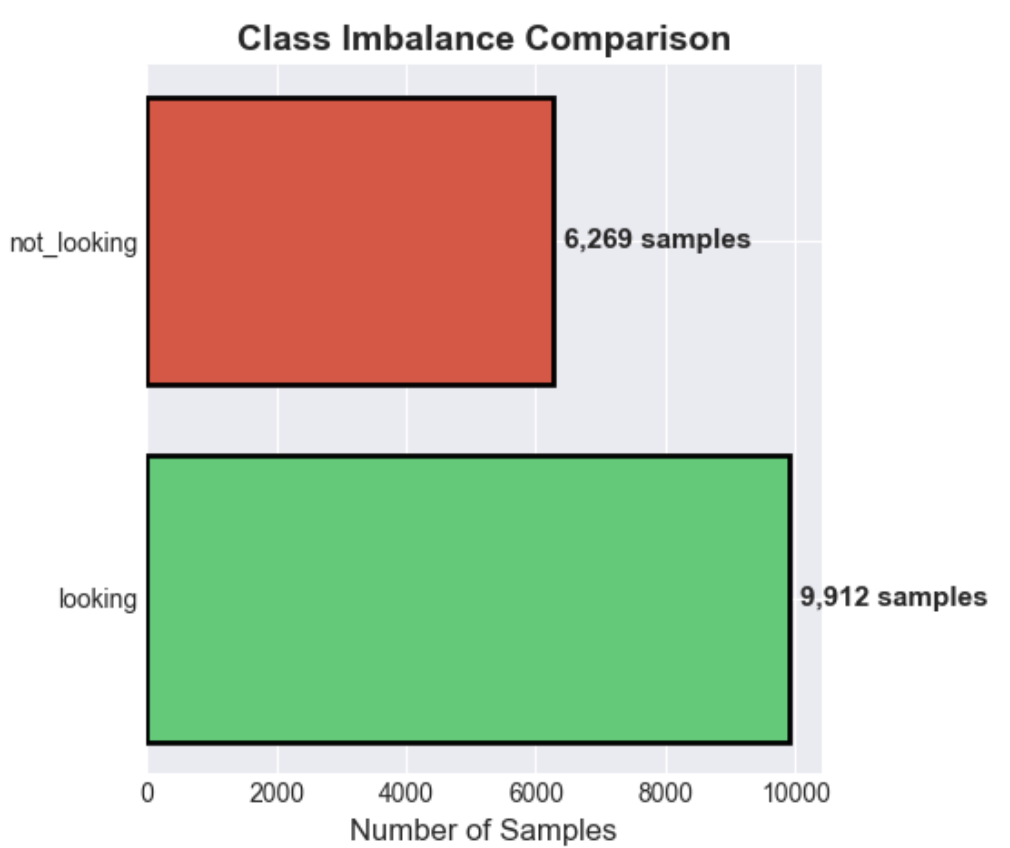

The imbalance is slightly lessened + we have a lot more images - although the dataset is still relatively small. As EyesOff is developed further I hope to increase the size of this dataset further. Building the dataset has been very time consuming, with most time spent labelling images.

### Re-evaluating the Model

This section discusses the results of the expanded data collection. To test if the data collection was successful, I ran a bunch of training runs each with different datasets. In each run, the model used is the same EfficientNetB0, the dataset just differs.

The following 3 tables show the performance on each task by a variety of different models, we will walk through the data setup for each model. There are 7 different models which we have evaluate, I will list them below in the following format \<model_name> - \<dataset setup>.

    - vcd_only - VCD dataset only
    - vcd_plus_v1 - VCD + v1 was my original extra data, it consists of lower quality and smaller images 
    - vcd_plus_v2 - VCD + v2 is the second set of extra data, consisting of high quality and large images (e.g. vlog style images)
    - vcd_plus_v2FULL - VCD + same as v2 but has more images, v2FULL has roughly 5000 more images than v2
    - vcd_plus_v1v2 - VCD + v1 and v2 
    - vcd_plus_v1_v2FULL - VCD + v1 and v2FULL
    - big_pretrain - VCD + vcd_plus_v2FULL, but in phase 1 I undertake a bigger pre-train, including both the selfie dataset and a driver awareness dataset

#### Evaluation Tables

Let's discuss the highlights in each table

| Model              | Accuracy | F1 Score |
|--------------------|----------|----------|
| vcd_only           | 79.44%   | 82.03%   |
| vcd_plus_v1        | 74.45%   | 75.05%   |
| vcd_plus_v2        | 74.35%   | 75.03%   |
| vcd_plus_v2FULL    | 76.07%   | 76.42%   |
| vcd_plus_v1v2      | 73.07%   | 71.75%   |
| vcd_plus_v1_v2FULL | 73.75%   | 72.67%   |
| big_pretrain       | 79.78%   | 80.95%   |

: Close Test Set Evaluation {#tbl-closetest}

big_pretrain has the best performance, it performs much better than vcd_plus_v2FULL alone - probably because the extra pre-train lets the model learn the relation between eyes and headpose and gaze direction better. vcd_only has good close performance too, probably because it is the closest to true close images. I.e. someone sitting at a screen and looking at and around it. This is surprising as vcd_only has the fewest images.

###### Mid Test
| Model              | Accuracy | F1 Score |
|--------------------|----------|----------|
| vcd_only           | 49.93%   | 37.33%   |
| vcd_plus_v1        | 61.28%   | 59.44%   |
| vcd_plus_v2        | 70.69%   | 68.31%   |
| vcd_plus_v2FULL    | 71.25%   | 69.15%   |
| vcd_plus_v1v2      | 69.77%   | 71.30%   |
| vcd_plus_v1_v2FULL | 74.37%   | 76.89%   |
| big_pretrain       | 67.74%   | 58.89%   |

: Mid Test Set Evaluation {#tbl-midtest}

Here we see the real impact of adding more data, vcd_plus_v1_v2FULL has the best performance at mid range - this does make sense as v1 has the most mid range looking images. vcd_plus_v2FULL comes in second which is also interesting as no images here are really mid range looking.

###### Close Subtle Test
| Model              | Accuracy | F1 Score |
|--------------------|----------|----------|
| vcd_only           | 56.78%   | 68.95%   |
| vcd_plus_v1        | 56.66%   | 68.55%   |
| vcd_plus_v2        | 57.91%   | 68.66%   |
| vcd_plus_v2FULL    | 64.45%   | 72.34%   |
| vcd_plus_v1v2      | 59.30%   | 69.61%   |
| vcd_plus_v1_v2FULL | 61.43%   | 70.79%   |
| big_pretrain       | 65.95%   | 73.41%   |

: Close Subtle Test Set Evaluation {#tbl-closesubtletest}

vcd_plus_v2FULL and big_pretrain come out on top here. This is the hardest case, it involves keeping headpose still and slightly looking to the side etc. As we improve the EyesOff model this will be a big area for improvement leading to a better user experience. 

So, if we bring all these results together we end up with the following models on top, as you probably guessed, vcd_plus_v2FULL and big_pretrain. Firstly, this highlights the importance of scale and secondly it is an amazing result! I am very happy to have trained a model which works, and one which exhibits some scaling laws. 

While big_pretrain has slightly better overall accuracy (71.16% vs 70.59%), I'm choosing vcd_plus_v2FULL because mid-range performance is critical for the shoulder surfing use case. This is where attackers are most likely to be positioned, and vcd_plus_v2FULL achieves 71.25% on mid-range vs big_pretrain's 67.74% - a significant 3.5% improvement where it matters most.

## Next Steps

There is still much to do, as I go back to building the EyesOff Application ready for re-launch I leave some notes here for my future self. Regarding the model, first step would be to collect more data. Next up is to reduce the model size and increase efficiency and there are many ways to do this, one way would be to quantize the model or utilise the ONNX format to compile the model, the other more difficult but more fruitful path would be to utilise a better architecture. Something like the YuNet architecture but tuned for the EyesOff task.

Thanks for reading and keep your eyes out for EyesOff!

---
<a id="1" style="text-decoration: none; color: inherit;"><sup>1</sup></a><a href="https://github.com/rehg-lab/eye-contact-cnn">https://github.com/rehg-lab/eye-contact-cnn</a>

<a id="2" style="text-decoration: none; color: inherit;"><sup>2</sup></a><a href="https://www.kaggle.com/datasets/jigrubhatt/selfieimagedetectiondataset">https://www.kaggle.com/datasets/jigrubhatt/selfieimagedetectiondataset</a>

<a id="3" style="text-decoration: none; color: inherit;"><sup>3</sup></a><a href="https://github.com/microsoft/VCD">https://github.com/microsoft/VCD</a>

<a id="4" style="text-decoration: none; color: inherit;"><sup>4</sup><a href="https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd">https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd</a>

<a id="5" style="text-decoration: none; color: inherit;"><sup>5</sup></a><a href="https://docs.openvino.ai/2023.3/omz_models_model_gaze_estimation_adas_0002.html">https://docs.openvino.ai/2023.3/omz_models_model_gaze_estimation_adas_0002.html</a>

<a id="6" style="text-decoration: none; color: inherit;"><sup>6</sup></a><a href="https://ai.google.dev/edge/mediapipe/solutions/vision/face_landmarker">https://ai.google.dev/edge/mediapipe/solutions/vision/face_landmarker</a>

<a id="7" style="text-decoration: none; color: inherit;"><sup>7</sup></a><a href='m&#97;&#105;&#108;&#116;o&#58;y%7&#53;s&#117;&#102;&#109;oh&#97;mm&#97;%&#54;4&#64;l%&#54;9ve&#46;&#99;&#111;m'>y&#117;&#115;u&#102;mo&#104;&#97;m&#109;ad&#64;l&#105;ve&#46;co&#109;

<a id="8" style="text-decoration: none; color: inherit;"><sup>8</sup></a> I realised that perhaps we ought to have two models running, one for close range faces and another for far. This poses some issues, battery drain first as we run two models and also deciding the threshold for what is close and far becomes a challenge. You could have a model which has two brances and a decision model which decides which branch to send the image down, but until we reduce the size of the EyesOff model we have to proceed with one.